# IBM Applied Data Science Capstone course

# Project: Segmenting and Clustering Neighborhoods in Toronto

# Author: Paschoal Molinari

# Date: 2021-03-02


_______________________________________________________________________________________________________

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#jump1">Installing and Importing libraries</a>

2.  <a href="#jump2">Creating a Toronto dataframe with Geospatial Data</a>

3.  <a href="#jump3">Visualizing the Neighborhoods in Toronto</a>
    
4.  <a href="#jump4">Creating a Toronto dataframe with all venues</a>
    
5.  <a href="#jump5">Clustering the Neighborhoods in Toronto</a>

6.  <a href="#jump6">Visualize and examine the Clustering</a>

    </font>
    </div>


### INTRODUCTION
- The business problem is finding neighborhoods in a specific city that are potentially good candidates for opening new restaurants. 
- Usually finding a good neighborhood for a new business is a time and resource-consuming effort and has some blind spots of factual data about demand and competition. 
- This problem affects many companies and entrepreneurs in the restaurant industry who need timely information for decision-making when choosing a new business location.
- Foursquare geospatial data can is used to uncover these spots.

<a id="jump1"></a>

# 1. Installing and Importing libraries

In [1]:
# importing libraries

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import urllib.request, urllib.parse, urllib.error
import ssl

# Installing beautifulsoup4
# !pip install beautifulsoup4 # uncomment this line if beautifulsoup4 is not already installed

from bs4 import BeautifulSoup

import numpy as np # library to handle data in a vectorized manner

import math

import json # library to handle JSON files

# !pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# %matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !pip install folium
import folium # map rendering library

print('\n Libraries imported.')


 Libraries imported.


<a id="jump2"></a>

# 2. Creating a Toronto dataframe with GeoSpatial Data

Creating a pandas dataframe with 5 columns: 
- Postal Code 
- Borough
- Neighborhood 
- Latitude
- Longitude.

This is done in two steps. Creating a one dataframe with Postal Code, Borough, Neighborhood and then creating a second one with Postal Code Latitude and Longitude.
After that join both dataframe in one.

In [2]:
# Reading and parsing the Wikipedia page using Beatifulsoup

# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

# Read and parse the wikipedia webpage that has the list of Toronto´s neighborhoods
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = urllib.request.urlopen(url, context=ctx).read()
soup = BeautifulSoup(html, 'html.parser')

In [3]:
# getting the wikipedia table
table = soup.find("table", { "class" : "wikitable sortable" })

# create an empty list Table of Postal Codes, Boroughs and Neighborhoods 
Table_PCBN = []

# finding and preparing rows, and append to the Table_PC
for row in table.findAll("tr"):
    cells = row.findAll("td")
    if len(cells) != 0:
        if cells[1].find(text=True) !='Not assigned\n':   # eliminating 'Not assigned' Borough rows
            table_row = []
            for i in range(0,3):
                tr_iten = cells[i].find(text=True)
                table_row.append(tr_iten[0:-1])
            Table_PCBN.append(table_row)

Lets create the first dataframe

In [4]:
# Creating a pandas dataframe 
df1 = pd.DataFrame(Table_PCBN)
df1.columns = ["Postal Code", "Borough", "Neighborhood"]

print('Shape', df1.shape , df1['Postal Code'].is_unique)
print('Neighborhood unique?', df1['Neighborhood'].is_unique)
df1.head()

Shape (103, 3) True
Neighborhood unique? False


,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


After dataframe inspection we can see that some neighborhoods have more than one Postal Code.

 Lets create the second dataframe

In [5]:
# reading csv file to the second dataframe. The csv file is courtesy of the course
df2 = pd.read_csv("Geospatial_Coordinates.csv")       
df2.columns = ["Postal Code", "Latitude", "Longitude"]

print('Shape', df2.shape,df2['Postal Code'].is_unique)
df2.head()

Shape (103, 3) True


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Lets join both dataframes

In [6]:
# New dataframe with geospatial location
df1 = df1.join(df2.set_index('Postal Code'), on='Postal Code')
toronto_geodata = df1

# Lets save and inspect the dataframe
toronto_geodata.to_csv("toronto_geodata.csv") # saving the data
print('Shape',toronto_geodata.shape)
toronto_geodata.head()

Shape (103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


The new dataframe has 103 rows and 5 columns. Some neighborhods have more than one postal code and Latitude/Longitude, then the primary key is 'Postal Code'.

<a id='jump3'></a>

# 3. Visualizing the Neighborhoods in Toronto

In [7]:
# finding the Toronto geospatial location
address = 'City of Toronto'

geolocator = Nominatim(user_agent="tot_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the City of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the City of Toronto are 43.6534817, -79.3839347.


Lets visualize the Neighborhoods in Toronto using Folium

In [8]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_geodata['Latitude'], toronto_geodata['Longitude'], toronto_geodata['Borough'], toronto_geodata['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<a id="jump4"></a>

# 4. Creating a Toronto dataframe with all venues from all the neighborhoods

Lets use Foursquare geospatial data.
First let defining Foursquare credentials and API version.

In [9]:
# Defining Foursquare credentials and API version

CLIENT_ID = 'YOUR_CLIENT_ID' # your Foursquare ID
CLIENT_SECRET = 'YOUR_CLIENT_SECRET' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: YOUR_CLIENT_ID
CLIENT_SECRET:YOUR_CLIENT_SECRET


Let's create a function to get all venues from all the neighborhoods

In [10]:
def getNearbyVenues(pcodes, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for pcode, name, lat, lng in zip(pcodes, names, latitudes, longitudes):
        print(name[:10], end=' | ')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
toronto_venues = getNearbyVenues(toronto_geodata['Postal Code'],toronto_geodata['Neighborhood'], toronto_geodata['Latitude'],  toronto_geodata['Longitude'], radius=500)
print('END')

Parkwoods | Victoria V | Regent Par | Lawrence M | Queen's Pa | Islington  | Malvern, R | Don Mills | Parkview H | Garden Dis | Glencairn | West Deane | Rouge Hill | Don Mills | Woodbine H | St. James  | Humewood-C | Eringate,  | Guildwood, | The Beache | Berczy Par | Caledonia- | Woburn | Leaside | Central Ba | Christie | Cedarbrae | Hillcrest  | Bathurst M | Thorncliff | Richmond,  | Dufferin,  | Scarboroug | Fairview,  | Northwood  | East Toron | Harbourfro | Little Por | Kennedy Pa | Bayview Vi | Downsview | The Danfor | Toronto Do | Brockton,  | Golden Mil | York Mills | Downsview | India Baza | Commerce C | North Park | Humber Sum | Cliffside, | Willowdale | Downsview | Studio Dis | Bedford Pa | Del Ray, M | Humberlea, | Birch Clif | Willowdale | Downsview | Lawrence P | Roselawn | Runnymede, | Weston | Dorset Par | York Mills | Davisville | Forest Hil | High Park, | Westmount | Wexford, M | Willowdale | North Toro | The Annex, | Parkdale,  | Canada Pos | Kingsview  | Agincourt |

### Let´s see the Toronto venues dataframe

In [12]:
# Save Toronto venues data in a csv file
toronto_venues.to_csv("toronto_venues.csv")

# See the Toronto venues dataframe
print('Shape', toronto_venues.shape)
print("Neighborhoods count",len(toronto_venues["Neighborhood"].unique()))
toronto_venues.head()

Shape (2117, 8)
Neighborhoods count 96


,Postal Code,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M4A,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,M4A,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,M4A,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


 <a id="jump5"></a>

# 5. Clustering the Neighborhoods in Toronto

Use the code cell below only if needed to restore Toronto venues data

In [13]:
# Read Toronto venues from saved csv file. Uncoment the below lines if necessary
toronto_venues = pd.DataFrame()
toronto_venues = pd.read_csv("toronto_venues.csv", index_col=0)
print('Shape', toronto_venues.shape)
toronto_venues.head()

Shape (2117, 8)


,Postal Code,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M3A,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M4A,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,M4A,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,M4A,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


### Let´s exclude small neighborhood with 10 or less venues
Small neighborhoods may need a diferent Foursquare data with larger radius like 1500 meters, and other considerations.

In [14]:
# Creating a dictionary for fast search of venues count per neighborhood
venues_count = toronto_venues.groupby('Postal Code').count()
venues_count = dict(venues_count['Venue'])

# search and drop rows with small neighborhoods (<11 venues)
for index, row in toronto_venues.iterrows():
    if venues_count[row[0]] < 11:
        toronto_venues.drop(index, inplace=True)

# Reset the index
toronto_venues.reset_index(inplace=True)
toronto_venues.drop(['index'], axis=1,inplace=True)

# Visualize Toronto venues data after exclusion
print('Neighborhoods', len(toronto_venues["Postal Code"].unique()))
print('Shape', toronto_venues.shape)
toronto_venues.head()

Neighborhoods 45
Shape (1878, 8)


,Postal Code,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


Let's find out how many unique categories can be curated from all the returned venues

In [15]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
print('There are {} uniques venue brands.'.format(len(toronto_venues['Venue'].unique())))

There are 245 uniques categories.
There are 1201 uniques venue brands.


## let's create the new dataframe and display the top 10 venues for each Postal Code

First lets do one hot encoding of all venues categories per postal code

In [16]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Postal Code'] = toronto_venues['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
print('Shape',toronto_onehot.shape)
toronto_onehot.head()

Shape (1878, 246)


,Postal Code,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M5A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Now lets substitute the encoding for the venues' mean in a given postal code

In [17]:
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
print('Shape',toronto_grouped.shape)
toronto_grouped.head()

Shape (45, 246)


,Postal Code,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.083333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.083333,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.000000,0

Now using the venues' mean data let´s create the dataframe with top 10 venues per postal code 

In [18]:
# function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

print('Dataframe Shape', neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

Dataframe Shape (45, 11)


,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1T,Pizza Place,Fast Food Restaurant,Pharmacy,Italian Restaurant,Fried Chicken Joint,Thai Restaurant,Chinese Restaurant,Gas Station,Noodle House,Bank
1,M1W,Fast Food Restaurant,Pharmacy,Chinese Restaurant,Breakfast Spot,Bubble Tea Shop,Sandwich Place,Supermarket,Bank,Furniture / Home Store,Electronics Store
2,M2J,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Japanese Restaurant,Mobile Phone Shop,Shoe Store,Bank,Bakery,Women's Store
3,M2N,Ramen Restaurant,Sandwich Place,Pizza Place,Café,Coffee Shop,Discount Store,Bank,Steakhouse,Ice Cream Shop,Fast Food Restaurant
4,M3C,Gym,Restaurant,Coffee Shop,Beer Store,Bike Shop,Supermarket,Japanese Restaurant,Discount Store,Dim Sum Restaurant,Chinese Restaurant


Let´s include the geospatial data 

In [20]:
# using the original dataframe (toronto_geodata) and droping all small neighborhoods (less than 11 venues)
toronto_merged = pd.DataFrame(toronto_geodata)

for index, row in toronto_merged.iterrows():
    try: 
        if venues_count[row[0]] < 11:
            toronto_merged.drop(index, inplace=True)
    except:
        toronto_merged.drop(index, inplace=True)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')

print('Dataframe Shape', toronto_merged.shape)
toronto_merged.head() # check the last columns!

Dataframe Shape (45, 15)


,Postal Code,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Pub,Theater,Yoga Studio,Shoe Store,Brewery
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Clothing Store,Accessories Store,Coffee Shop,Boutique,Miscellaneous Shop,Event Space,Furniture / Home Store,Gift Shop,Vietnamese Restaurant,Discount Store
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burger Joint,Burrito Place,Café
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,Clothing Store,Coffee Shop,Italian Restaurant,Japanese Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Bubble Tea Shop,Café,Electronics Store,Movie Theater
13,M3C,North York,Don Mills,43.725900,-79.340923,Gym,Restaurant,Coffee Shop,Beer Store,Bike Shop,Supermarket,Japanese Restaurant,Discount Store,Dim Sum Restaurant,Chinese Restaurant


Lets find all Restaurants Categories to study the competition

In [21]:
# finding all Restaurants categories
toronto_venue_categories = list(toronto_onehot.columns[:-1])
toronto_restaurants_categories = list()
for tvc in toronto_venue_categories:
    if tvc[-10:] == "Restaurant":
        toronto_restaurants_categories.append(tvc)
print('Number of restaurants categories:',len(toronto_restaurants_categories))
print(toronto_restaurants_categories)

Number of restaurants categories: 46
['American Restaurant', 'Asian Restaurant', 'Belgian Restaurant', 'Brazilian Restaurant', 'Cajun / Creole Restaurant', 'Caribbean Restaurant', 'Chinese Restaurant', 'Colombian Restaurant', 'Comfort Food Restaurant', 'Cuban Restaurant', 'Dim Sum Restaurant', 'Doner Restaurant', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Ethiopian Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant', 'French Restaurant', 'German Restaurant', 'Gluten-free Restaurant', 'Greek Restaurant', 'Indian Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Korean Restaurant', 'Latin American Restaurant', 'Malay Restaurant', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'Modern European Restaurant', 'Molecular Gastronomy Restaurant', 'Moroccan Restaurant', 'New American Restaurant', 'Portuguese Restaurant', 'Ramen Restaurant', 'Restaurant', 'Seafood Restaurant', 'Sushi Restaurant', 'Taiwanese Restaura

Let's create a dataframe with new analytics columns:
   - All venues count - All venues of all categories in the neighborhood 
   - Restaurant count - All the restaurant from all restaurant categories in the neighborhood
   - Italian Restaurant count after - All Italian restaurants in the neighborhood plus the new one to be open (simulating the numbers after open the new restaurant)
   - Italian Restaurant mean after - the mean of Italian restaurants in the neighborhood plus the new one to be open (simulating the numbers after open the new restaurant). The lower the mean the better is the chance of success.
   - Restaurant mean after - the mean of all restaurants in the neighborhood plus the new one to be open (simulating the numbers after open the new restaurant). The lower the mean the better is the chance of success.
   - Normalized Italian Restaurant mean after
   - Normalized Restaurant mean after

In [22]:
# lets define the venue category that will be evaluated
venue_category = "Italian Restaurant" 

#  Creating a new dataframe with Neighborhoods and its venues count
toronto_rest = pd.DataFrame(toronto_venues['Postal Code'])
toronto_rest['All venues Count'] = toronto_venues['Venue']
toronto_rest = toronto_rest.groupby('Postal Code').count().reset_index()

# Lets create eight new columns
restaurant_total_len = toronto_rest.shape[0]
restaurant_total = [0]*restaurant_total_len
for rest_cat in toronto_restaurants_categories:
    rest_list = list(toronto_onehot.groupby('Postal Code').sum()[rest_cat])
    for i in range(0,restaurant_total_len):
        restaurant_total[i] = restaurant_total[i] + rest_list[i]

toronto_rest["Restaurant count"] = restaurant_total
toronto_rest[venue_category + " count"] = list(toronto_onehot.groupby('Postal Code').sum()[venue_category])
toronto_rest[venue_category + " mean"] = list(toronto_onehot.groupby('Postal Code').mean().reset_index()[venue_category])

# add one to the total like creating a new venue in the neighborhood
toronto_rest[venue_category + " count after"] = toronto_rest[venue_category + " count"] + 1 

# Calculate the venue category mean AFTER creating the new venue
toronto_rest[venue_category + " mean after"] = toronto_rest[venue_category + " count after"] / toronto_rest["All venues Count"]

# Calculate the Restaurant mean AFTER creating the new venue
toronto_rest["Restaurant mean after"] = (toronto_rest["Restaurant count"] + 1) / toronto_rest["All venues Count"]

# Sort by ascending mean value AFTER new venue creation. 
# The lower the mean the better chance of success for the new venue in the specific neighborhood
toronto_rest.sort_values(by=venue_category + " mean after", inplace=True, ignore_index=True)

# lets create two columns with normalized means 
max_Italian_Restaurant_mean_after = toronto_rest[venue_category + " mean after"].max()
max_Restaurant_mean_after = toronto_rest["Restaurant mean after"].max()
toronto_rest['norma_IRMA'] = toronto_rest[venue_category + " mean after"] / max_Italian_Restaurant_mean_after
toronto_rest['norma_RMA'] = toronto_rest["Restaurant mean after"] / max_Restaurant_mean_after

# Lets drop unnecessary data
toronto_rest.drop("Italian Restaurant count", axis = 1, inplace=True)
toronto_rest.drop("Italian Restaurant mean", axis = 1, inplace=True)

# Lets visualise the new data 
print('Shape', toronto_rest.shape)
toronto_rest.head()

Shape (45, 8)


,Postal Code,All venues Count,Restaurant count,Italian Restaurant count after,Italian Restaurant mean after,Restaurant mean after,norma_IRMA,norma_RMA
0,M5H,93,24,1,0.010753,0.268817,0.064516,0.537634
1,M4Y,79,26,1,0.012658,0.341772,0.075949,0.683544
2,M2J,69,13,1,0.014493,0.202899,0.086957,0.405797
3,M5T,64,18,1,0.015625,0.296875,0.093750,0.593750
4,M5E,56,11,1,0.017857,0.214286,0.107143,0.428571


In [23]:
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_rest.set_index('Postal Code'), on='Postal Code')

In [24]:
toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,All venues Count,Restaurant count,Italian Restaurant count after,Italian Restaurant mean after,Restaurant mean after,norma_IRMA,norma_RMA
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Pub,Theater,Yoga Studio,Shoe Store,Brewery,44,3,1,0.022727,0.090909,0.136364,0.181818
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Clothing Store,Accessories Store,Coffee Shop,Boutique,Miscellaneous Shop,Event Space,Furniture / Home Store,Gift Shop,Vietnamese Restaurant,Discount Store,13,1,1,0.076923,0.153846,0.461538,0.307692
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burger Joint,Burrito Place,Café,31,5,2,0.064516,0.193548,0.387097,0.387097
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,Clothing Store,Coffee Shop,Italian Restaurant,Japanese Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Bubble Tea Shop,Café,Electronics Store,Movie Theater,100,21,4,0.040000,0.220000,0.240000,0.440000
13,M3C,North York,Don Mills,43.725900,-79.340923,Gym,Restaurant,Coffee Shop,Beer Store,Bike Shop,Supermarket,Japanese Restaurant,Discount Store,Dim Sum Restaurant,Chinese Restaurant,20,7,2,0.100000,0.400000,0.600000,0.800000


## Let´s use the Machine Learning K-means to cluster the neighborhoods

Two new statistical features of high relevance are calculated from dozens of features:
- Mean of restaurants by neighborhood (all categories of restaurants). The lower the mean the higher the need for restaurants in general.
- Mean of Italian restaurants by neighborhood. The lower the mean the higher the need for Italian restaurants.

The Machine Learning K-Means is applied to cluster the neighborhoods using the normalized features above (norma_IRMA and norma_RMA). The final clusters are then sequenced by the size of the vector representing each cluster in ascending order.

In [25]:
# first let´s prepare normalized data to feed the Kmeans
toronto_normalized_means = pd.DataFrame()
toronto_normalized_means['norma_IRMA'] = list(toronto_merged['norma_IRMA'])
toronto_normalized_means['norma_RMA'] = list(toronto_merged['norma_RMA'])

print('Shape',toronto_normalized_means.shape)
toronto_normalized_means.head()

Shape (45, 2)


,norma_IRMA,norma_RMA
0,0.136364,0.181818
1,0.461538,0.307692
2,0.387097,0.387097
3,0.240000,0.440000
4,0.600000,0.800000


### Now let´s cluster the neighborhoods using the venues means data

In [26]:
# set number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_normalized_means)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 8, 8, 3, 0, 3, 4, 2, 1, 7])

Lets create insert the 'kmeans labels' column and visualize

In [27]:
# add clustering labels
toronto_merged.insert(len(toronto_merged.columns),'kmeans labels', kmeans.labels_)

Lets reorder with the Clusters' vector norm. The final clusters are then sequenced by the size of the vector representing each cluster in ascending order.

In [28]:
# First calculate the norm of each vector representing the clusters
mean_vector_norm = [[0,0]]*kclusters
for i in range(0,kclusters):
    cluster_block = toronto_merged.loc[lambda toronto_merged: toronto_merged["kmeans labels"] == i ]
    x_mean = cluster_block['norma_IRMA'].mean()
    y_mean = cluster_block['norma_RMA'].mean()
    mean_vector_norm[i] = [i, math.sqrt(x_mean**2 + y_mean**2)] # calculating the vector norm

# Second, reorder the position of norms
for i in range(0,kclusters):
    for ii in range(0,kclusters-1):
        aa = mean_vector_norm[ii]
        bb = mean_vector_norm[ii+1]
        if aa[1] > bb[1]:
            mean_vector_norm[ii] = bb
            mean_vector_norm[ii+1] = aa

# Lets make a transformation list from kmeans.labels_ to sequential mean_vector_norm
cluster_transform = [0]*kclusters
for i in range(0,kclusters):
    cluster_transform[mean_vector_norm[i][0]] = i 

# Lets make the transformation
len_cluster_labels = len(kmeans.labels_)
Cluster = [0]*len_cluster_labels
for i in range(0,len_cluster_labels):
    Cluster[i] = cluster_transform[kmeans.labels_[i]]

# add clustering labels
toronto_merged.insert(1, 'Cluster', Cluster)
toronto_merged.sort_values(by="Cluster", inplace=True, ignore_index=True)

print('Shape',toronto_merged.shape)
toronto_merged.head()

Shape (45, 24)


,Postal Code,Cluster,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,All venues Count,Restaurant count,Italian Restaurant count after,Italian Restaurant mean after,Restaurant mean after,norma_IRMA,norma_RMA,kmeans labels
0,M5A,0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Pub,Theater,Yoga Studio,Shoe Store,Brewery,44,3,1,0.022727,0.090909,0.136364,0.181818,2
1,M5R,0,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,Café,Sandwich Place,Coffee Shop,Liquor Store,Middle Eastern Restaurant,Flower Shop,Park,Donut Shop,Indian Restaurant,Pharmacy,20,2,1,0.050000,0.150000,0.300000,0.300000,2
2,M5J,0,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Coffee Shop,Aquarium,Café,Hotel,Scenic Lookout,Sporting Goods Shop,Italian Restaurant,Fried Chicken Joint,Restaurant,Brewery,100,13,4,0.040000,0.140000,0.240000,0.280000,2
3,M4G,0,East York,Leaside,43.709060,-79.363452,Sporting Goods Shop,Coffee Shop,Furniture / Home Store,Shopping Mall,Burger Joint,Bank,Sushi Restaurant,Supermarket,Fish & Chips Shop,Sports Bar,34,3,1,0.029412,0.117647,0.176471,0.235294,2
4,M3H,0,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,Coffee Shop,Bank,Fried Chicken Joint,Bridal Shop,Sandwich Place,Diner,Restaurant,Intersection,Supermarket,Middle Eastern Restaurant,22,3,1,0.045455,0.181818,0.272727,0.363636,2


<a id="jump6"></a>

# 6. Visualize and examine the Clustering

## Lets visualize the cluster geospatial map

The colors in the geospatial are the same in the plot

In [29]:
# Define cluster´s color map for the geospatial map and the plot

# moderate non sequential color map. Uncomment if you like
cluster_color = ['darkslateblue','salmon','darkslategray','darkolivegreen','darkmagenta','firebrick','chocolate','sandybrown','indigo']

# 'magma' sequential color map. Uncomment if you like
# cluster_color = ['#000000', '#120d00', '#350f00', '#5d1700', '#822500', '#a93200', '#d04100', '#ee5d00', '#fb8800']

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=cluster_color[cluster],
        fill=True,
        fill_color=cluster_color[cluster],
        fill_opacity=0.7).add_to(map_clusters)

# save a file copy of the map
map_clusters.save("toronto_clusters_map.html")

# show the map inline
map_clusters

## Lets plot the Clusters

Everytime you execute this notebook getting data from Foursquare the cluster will change somehow.

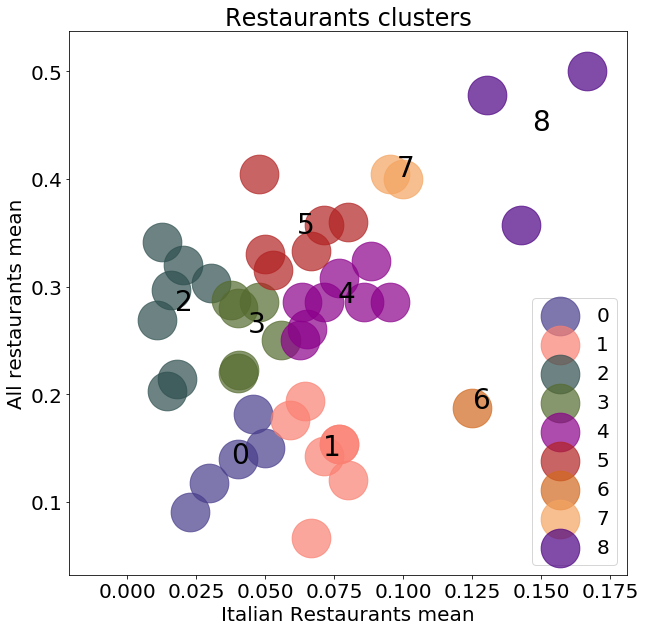

In [31]:
# Creating a plot visualization of the means Clusters
plt.figure(1,figsize=[10,10])

dot_size = 1500
dot_alpha = 0.7

# plot colors will be the same of the geospatial map colors

# dot_markers = ["o","^","X","s","P","*","h","H","D"]
# dot_markers = 9*["o"]

for i in range(0,kclusters):
    plt.rc('font', size=20)
    cluster_plot = toronto_merged.loc[lambda toronto_merged: toronto_merged["Cluster"] == i ]
    plt.scatter(cluster_plot['Italian Restaurant mean after'],cluster_plot['Restaurant mean after'], c=cluster_color[i],  s=dot_size, alpha=dot_alpha, cmap='magma')
    x_mean = cluster_plot['Italian Restaurant mean after'].mean()
    y_mean = cluster_plot['Restaurant mean after'].mean()
    plt.rc('font', size=28)
    plt.annotate(i,[x_mean,y_mean])
    
plt.rc('font', size=20)  
plt.title('Restaurants clusters')
plt.xlabel('Italian Restaurants mean')
plt.ylabel('All restaurants mean')
plt.rc('font', size=20) 
plt.legend('012345678',loc='lower right')
plt.savefig('toronto_clusters_plot') # save a file copy of the plot
plt.show(1)

- Each Cluster has a color and number from 0 to 8.
- The closer the cluster is to the point to (0,0) the lower the combined means and lower is the competition.

Let's see, more clearly, the position of the center of the clusters.

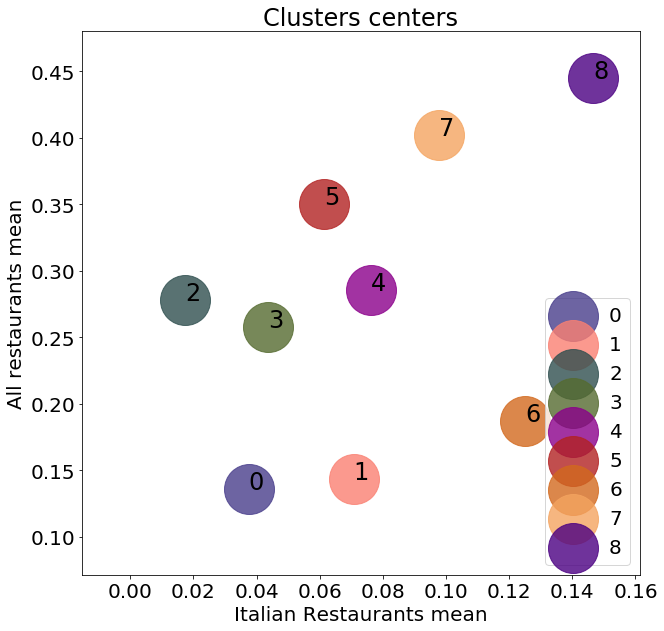

In [32]:
# Creating a plot visualization of the means Clusters
plt.figure(2,figsize=[10,10])

dot_size = 2500
dot_alpha = 0.8

# plot colors will be the same of the geospatial map colors

#set font size of labels on matplotlib plots
plt.rc('font', size=20) 

for i in range(0,kclusters):
    cluster_plot = toronto_merged.loc[lambda toronto_merged: toronto_merged["Cluster"] == i ]
    x_mean = cluster_plot['Italian Restaurant mean after'].mean()
    y_mean = cluster_plot['Restaurant mean after'].mean()
    plt.rc('font', size=20)
    plt.scatter([x_mean], y_mean, c=cluster_color[i],  s=dot_size, alpha=dot_alpha, cmap='magma')
    plt.rc('font', size=24)
    plt.annotate(i,[x_mean,y_mean])

    
plt.rc('font', size=20)  
plt.legend('012345678',loc='lower right')  

plt.grid(False)
plt.title('Clusters centers')
plt.xlabel('Italian Restaurants mean')
plt.ylabel('All restaurants mean')
plt.savefig('toronto_clusters_centers_plot') # save a file copy of the plot
plt.show(2)

## Let´s examine the Clusters data

First the Cluster 0, because it is the closest to point (0,0).  This is a very promissing cluster with low means. The top 10 venues dont show much restaurants categories.

In [33]:
toronto_merged.loc[toronto_merged['Cluster'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]-3))  ]]

,Borough,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,All venues Count,Restaurant count,Italian Restaurant count after,Italian Restaurant mean after,Restaurant mean after
0,Downtown Toronto,-79.360636,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Pub,Theater,Yoga Studio,Shoe Store,Brewery,44,3,1,0.022727,0.090909
1,Central Toronto,-79.405678,Café,Sandwich Place,Coffee Shop,Liquor Store,Middle Eastern Restaurant,Flower Shop,Park,Donut Shop,Indian Restaurant,Pharmacy,20,2,1,0.050000,0.150000
2,Downtown Toronto,-79.381752,Coffee Shop,Aquarium,Café,Hotel,Scenic Lookout,Sporting Goods Shop,Italian Restaurant,Fried Chicken Joint,Restaurant,Brewery,100,13,4,0.040000,0.140000
3,East York,-79.363452,Sporting Goods Shop,Coffee Shop,Furniture / Home Store,Shopping Mall,Burger Joint,Bank,Sushi Restaurant,Supermarket,Fish & Chips Shop,Sports Bar,34,3,1,0.029412,0.117647
4,North York,-79.442259,Coffee Shop,Bank,Fried Chicken Joint,Bridal Shop,Sandwich Place,Diner,Restaurant,Intersection,Supermarket,Middle Eastern Restaurant,22,3,1,0.045455,0.181818


Second the Cluster 1, because it has a low value of All restaurant mean. The top 10 venues dont show much restaurants categories.

In [34]:
toronto_merged.loc[toronto_merged['Cluster'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]-3))  ]]

,Borough,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,All venues Count,Restaurant count,Italian Restaurant count after,Italian Restaurant mean after,Restaurant mean after
5,Downtown Toronto,-79.394420,Airport Service,Airport Lounge,Airport Terminal,Harbor / Marina,Boat or Ferry,Airport,Airport Food Court,Rental Car Location,Sculpture Garden,Plane,15,0,1,0.066667,0.066667
6,East Toronto,-79.321558,Light Rail Station,Yoga Studio,Garden Center,Brewery,Farmers Market,Fast Food Restaurant,Burrito Place,Restaurant,Skate Park,Auto Workshop,17,2,1,0.058824,0.176471
7,West Toronto,-79.428191,Café,Coffee Shop,Breakfast Spot,Nightclub,Bakery,Yoga Studio,Stadium,Burrito Place,Restaurant,Climbing Gym,25,2,2,0.080000,0.120000
8,West Toronto,-79.442259,Pharmacy,Bakery,Grocery Store,Music Venue,Bank,Bar,Café,Supermarket,Pool,Middle Eastern Restaurant,14,1,1,0.071429,0.142857
9,Etobicoke,-79.520999,Grocery Store,Thrift / Vintage Store,Fast Food Restaurant,Sandwich Place,Burger Joint,Bakery,Supplement Shop,Discount Store,Tanning Salon,Hardware Store,13,1,1,0.076923,0.153846
10,Downtown Toronto,-79.389494,Coffee Shop,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burger Joint,Burrito Place,Café,31,5,2,0.064516,0.193548
11,North York,-79.464763,Clothing Store,Accessories Store,Coffee Shop,Boutique,Miscellaneous Shop,Event Space,Furniture / Home Store,Gift Shop,Vietnamese Restaurant,Discount Store,13,1,1,0.076923,0.153846


Third the Cluster 2, because it has a low Italian restaurant mean. Most neighborhoods dont have a Italian restaurant.

In [35]:
toronto_merged.loc[toronto_merged['Cluster'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]-3))  ]]

,Borough,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,All venues Count,Restaurant count,Italian Restaurant count after,Italian Restaurant mean after,Restaurant mean after
12,Downtown Toronto,-79.383160,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Yoga Studio,Burger Joint,Pub,Hotel,Fast Food Restaurant,79,26,1,0.012658,0.341772
13,Downtown Toronto,-79.384568,Coffee Shop,Café,Restaurant,Clothing Store,Bakery,Gym,Deli / Bodega,Thai Restaurant,Steakhouse,Pizza Place,93,24,1,0.010753,0.268817
14,Downtown Toronto,-79.373306,Coffee Shop,Cocktail Bar,Bakery,Beer Bar,Farmers Market,Pharmacy,Cheese Shop,Seafood Restaurant,Restaurant,Breakfast Spot,56,11,1,0.017857,0.214286
15,North York,-79.346556,Clothing Store,Coffee Shop,Fast Food Restaurant,Restaurant,Japanese Restaurant,Mobile Phone Shop,Shoe Store,Bank,Bakery,Women's Store,69,13,1,0.014493,0.202899
16,Downtown Toronto,-79.382280,Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Gym,Deli / Bodega,Salad Place,Steakhouse,American Restaurant,100,31,2,0.020000,0.320000
17,Downtown Toronto,-79.400049,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Mexican Restaurant,Bar,Park,Bakery,Grocery Store,Gaming Cafe,64,18,1,0.015625,0.296875
18,North York,-79.408493,Ramen Restaurant,Sandwich Place,Pizza Place,Café,Coffee Shop,Discount Store,Bank,Steakhouse,Ice Cream Shop,Fast Food Restaurant,33,9,1,0.030303,0.303030


Fourth the Cluster 3, because it has a medium combined Italian restaurant mean and All restaurant mean. It is not as good as the three previous clusters.

In [36]:
toronto_merged.loc[toronto_merged['Cluster'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]-3))  ]]

,Borough,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,All venues Count,Restaurant count,Italian Restaurant count after,Italian Restaurant mean after,Restaurant mean after
19,Downtown Toronto,-79.374846,Coffee Shop,Seafood Restaurant,Bakery,Hotel,Restaurant,Café,Beer Bar,Cocktail Bar,Japanese Restaurant,Italian Restaurant,99,21,4,0.040404,0.222222
20,Downtown Toronto,-79.378937,Clothing Store,Coffee Shop,Italian Restaurant,Japanese Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Bubble Tea Shop,Café,Electronics Store,Movie Theater,100,21,4,0.040000,0.220000
21,East Toronto,-79.340923,Coffee Shop,Café,Gastropub,American Restaurant,Bakery,Brewery,Bookstore,Convenience Store,Latin American Restaurant,Seafood Restaurant,36,8,2,0.055556,0.250000
22,East York,-79.349372,Indian Restaurant,Yoga Studio,Pizza Place,Sandwich Place,Burger Joint,Fast Food Restaurant,Discount Store,Restaurant,Middle Eastern Restaurant,Supermarket,21,5,1,0.047619,0.285714
23,Downtown Toronto,-79.375418,Café,Coffee Shop,Gastropub,Cocktail Bar,American Restaurant,Cosmetics Shop,Restaurant,Moroccan Restaurant,Creperie,Bakery,80,22,3,0.037500,0.287500
24,Downtown Toronto,-79.381576,Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Italian Restaurant,Bakery,Seafood Restaurant,American Restaurant,Salad Place,100,27,4,0.040000,0.280000


Please, as exercise analyse the other 5 clusters.

As good potential candidates neighborhoods the best Cluster is number 0.
- Is the closest to point (0,0).  This is a very promissing cluster with very low means.
- The top 10 venues dont show much restaurants categories.

The next step in the decision-making process is get more information about the Cluster 0 neighborhoods.

You can find more information and data files in the project report.

### Thanks for your atention!